# DSAI 456 - Final Lab Exam A - SOLUTION

**Name:** Your Name  
**ID:** Your ID

---

# Coding Section
- Any given code is optional to help you; if you want to edit it, modify it, or implement your own, it's okay.

## Imports

In [1]:
import matplotlib.pyplot as plt
import librosa
import librosa.display
import pandas as pd
import numpy as np
import os

## Reading Data

Write a Python Code that reads four audio files (WAV format). For each file, load the audio using librosa and store the results in a dictionary where the **keys** are the **labels** and the values are tuples containing:
- The audio signal
- The sampling rate

Output Example:
- { "e": (signal_e, sr_e) }

In [2]:
# Define labels for the audio files
labels = ["e", "j", "3", "7"]

# Dictionary to store audio data
audio_dict = {}

# Path to audio files (adjust this path to where your audio files are located)
audio_folder = "./"  # Change this to your audio folder path

# Load each audio file
for label in labels:
    # Construct the file path - adjust naming convention as needed
    # Common naming patterns: "e.wav", "label_e.wav", etc.
    file_path = os.path.join(audio_folder, f"{label}.wav")

    # Check if file exists
    if os.path.exists(file_path):
        # Load audio using librosa
        signal, sr = librosa.load(file_path, sr=None)  # sr=None preserves original sample rate
        audio_dict[label] = (signal, sr)
        print(f"Loaded '{label}': signal shape = {signal.shape}, sample rate = {sr}")
    else:
        print(f"Warning: File not found for label '{label}' at {file_path}")

print(f"\nLoaded {len(audio_dict)} audio files.")
print("Audio dictionary keys:", list(audio_dict.keys()))


Loaded 0 audio files.
Audio dictionary keys: []


### Alternative: Generate Sample Audio for Testing (if files not available)

In [3]:
# If audio files are not available, generate synthetic audio for testing
# This simulates keystroke sounds with different characteristics

if len(audio_dict) == 0:
    print("Generating synthetic audio data for testing...")

    sample_rate = 22050

    def generate_keystroke(n_strokes=10, base_freq=200, sr=22050):
        """Generate synthetic keystroke-like sounds."""
        full_signal = np.array([])

        for i in range(n_strokes):
            # Each stroke: short burst with decay
            duration = 0.05 + np.random.rand() * 0.03  # 50-80ms
            t = np.linspace(0, duration, int(sr * duration))

            # Frequency with some variation
            freq = base_freq + np.random.randn() * 50

            # Create stroke sound with envelope
            envelope = np.exp(-t * 30)  # Fast decay
            stroke = np.sin(2 * np.pi * freq * t) * envelope
            stroke += 0.3 * np.sin(2 * np.pi * freq * 2 * t) * envelope  # Harmonics
            stroke += 0.1 * np.random.randn(len(t)) * envelope  # Noise

            # Silence between strokes
            silence_duration = 0.1 + np.random.rand() * 0.15
            silence = np.zeros(int(sr * silence_duration))

            full_signal = np.concatenate([full_signal, stroke, silence])

        return full_signal.astype(np.float32)

    # Generate different "keystroke" patterns for each label
    np.random.seed(42)  # For reproducibility
    audio_dict = {
        "e": (generate_keystroke(10, base_freq=180), sample_rate),
        "j": (generate_keystroke(10, base_freq=220), sample_rate),
        "3": (generate_keystroke(10, base_freq=260), sample_rate),
        "7": (generate_keystroke(10, base_freq=300), sample_rate),
    }

    for label, (signal, sr) in audio_dict.items():
        print(f"Generated '{label}': signal shape = {signal.shape}, sample rate = {sr}")

Generating synthetic audio data for testing...
Generated 'e': signal shape = (53074,), sample rate = 22050
Generated 'j': signal shape = (56690,), sample rate = 22050
Generated '3': signal shape = (55697,), sample rate = 22050
Generated '7': signal shape = (52415,), sample rate = 22050


### Visualize Audio Signals

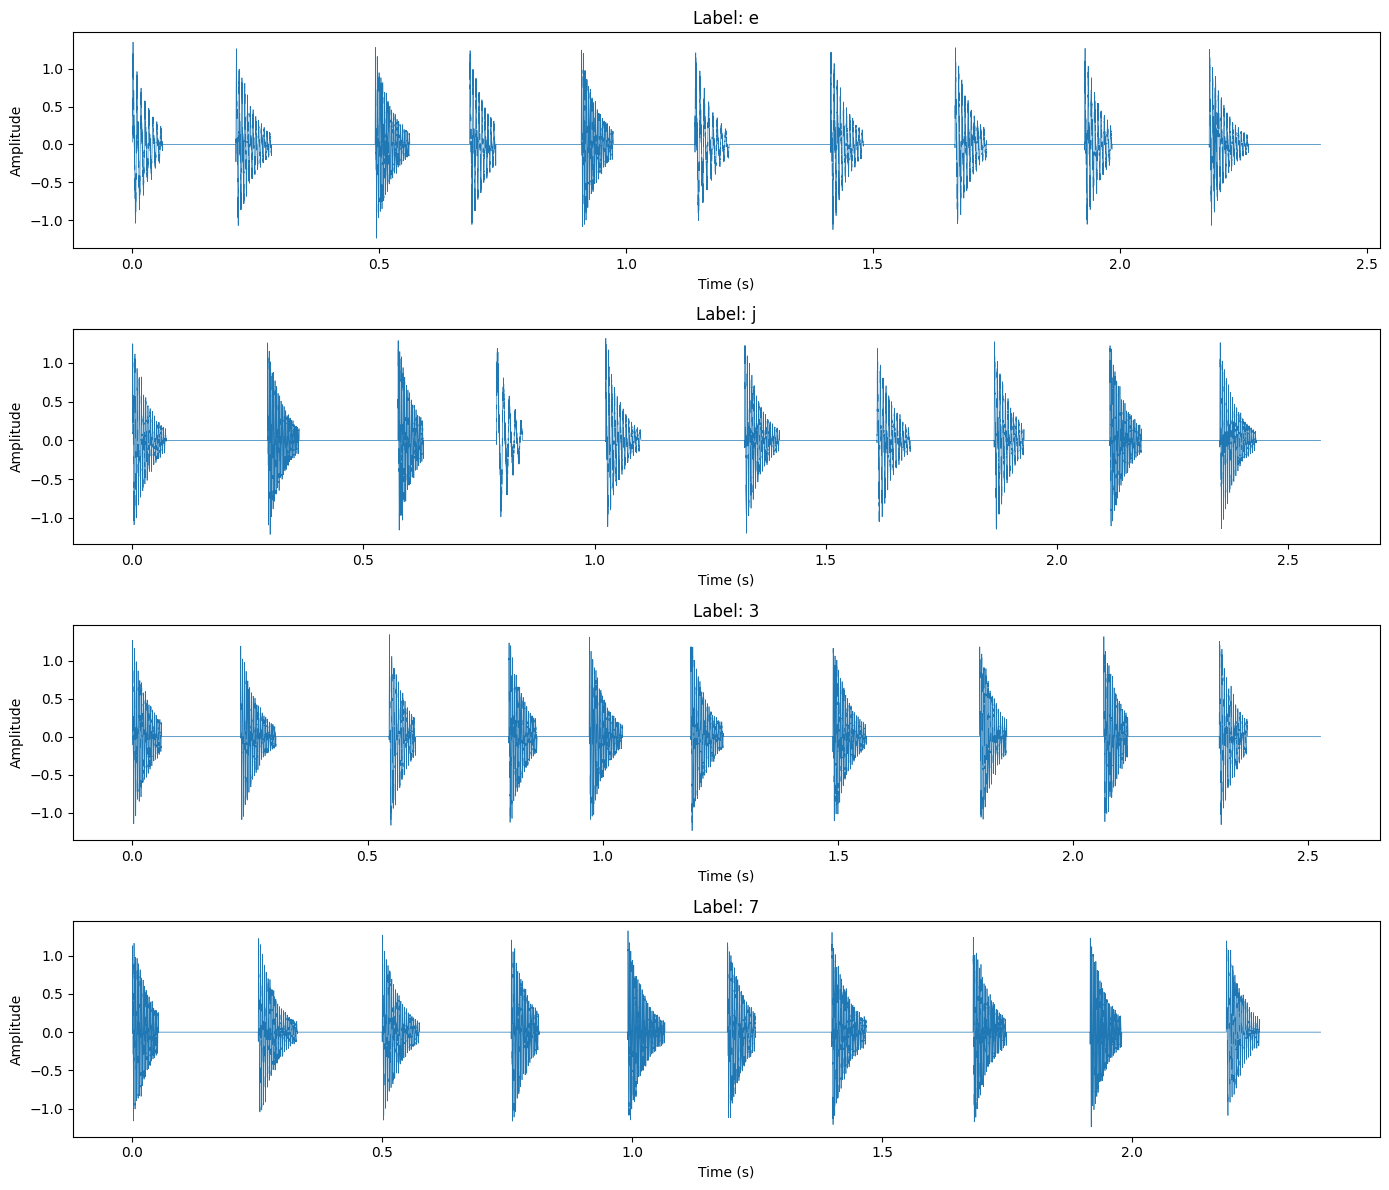

In [4]:
# Plot waveforms
fig, axes = plt.subplots(len(audio_dict), 1, figsize=(14, 3*len(audio_dict)))

for idx, (label, (signal, sr)) in enumerate(audio_dict.items()):
    ax = axes[idx] if len(audio_dict) > 1 else axes
    time = np.arange(len(signal)) / sr
    ax.plot(time, signal, linewidth=0.5)
    ax.set_title(f"Label: {label}")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude")

plt.tight_layout()
plt.show()

---
## Isolation

Implement a function to isolate individual strokes (audio segments) from the continuous audio signal.

In [5]:
def isolator(signal, sample_rate, threshold_db=-30, min_duration_ms=20,
             max_duration_ms=200, padding_ms=10):
    """
    Isolate individual strokes from an audio signal using energy-based detection.

    Parameters:
    -----------
    signal : np.ndarray
        Input audio signal (1D array).
    sample_rate : int
        Sampling rate of the audio.
    threshold_db : float
        Threshold in dB below peak for detecting active segments.
    min_duration_ms : float
        Minimum duration of a valid stroke in milliseconds.
    max_duration_ms : float
        Maximum duration of a stroke in milliseconds.
    padding_ms : float
        Padding to add before and after each detected stroke.

    Returns:
    --------
    strokes : list of np.ndarray
        A list of 1D arrays, each containing an isolated audio segment (stroke).
    """
    # Convert parameters to samples
    min_samples = int(min_duration_ms * sample_rate / 1000)
    max_samples = int(max_duration_ms * sample_rate / 1000)
    padding_samples = int(padding_ms * sample_rate / 1000)

    # Compute frame-level energy using RMS
    frame_length = 512
    hop_length = 256

    # Compute RMS energy
    rms = librosa.feature.rms(y=signal, frame_length=frame_length, hop_length=hop_length)[0]

    # Convert to dB
    rms_db = librosa.amplitude_to_db(rms, ref=np.max)

    # Find frames above threshold
    active_frames = rms_db > threshold_db

    # Find contiguous regions of active frames
    strokes = []
    in_stroke = False
    stroke_start = 0

    for i, is_active in enumerate(active_frames):
        if is_active and not in_stroke:
            # Start of a new stroke
            stroke_start = i
            in_stroke = True
        elif not is_active and in_stroke:
            # End of current stroke
            stroke_end = i
            in_stroke = False

            # Convert frame indices to sample indices
            start_sample = max(0, stroke_start * hop_length - padding_samples)
            end_sample = min(len(signal), stroke_end * hop_length + padding_samples)

            # Check duration constraints
            duration = end_sample - start_sample
            if min_samples <= duration <= max_samples:
                stroke = signal[start_sample:end_sample]
                strokes.append(stroke)

    # Handle case where signal ends during a stroke
    if in_stroke:
        start_sample = max(0, stroke_start * hop_length - padding_samples)
        end_sample = len(signal)
        duration = end_sample - start_sample
        if min_samples <= duration <= max_samples:
            stroke = signal[start_sample:end_sample]
            strokes.append(stroke)

    return strokes

Found 10 strokes in 'e'


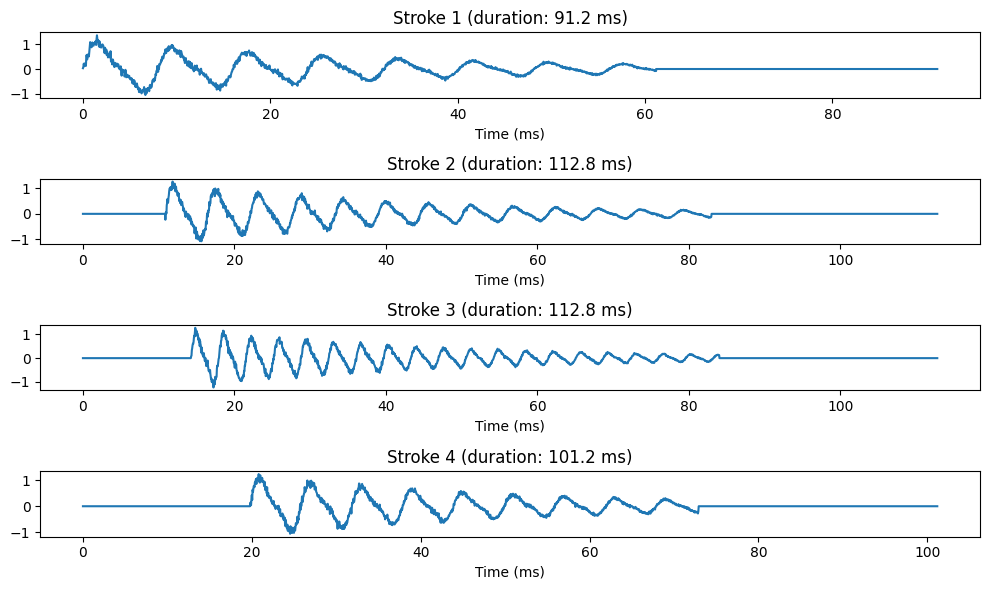

In [6]:
# Test the isolator on one signal
test_label = list(audio_dict.keys())[0]
test_signal, test_sr = audio_dict[test_label]
test_strokes = isolator(test_signal, test_sr)
print(f"Found {len(test_strokes)} strokes in '{test_label}'")

# Plot first few strokes
if len(test_strokes) > 0:
    fig, axes = plt.subplots(min(4, len(test_strokes)), 1, figsize=(10, 6))
    for i, stroke in enumerate(test_strokes[:4]):
        ax = axes[i] if len(test_strokes) > 1 else axes
        time = np.arange(len(stroke)) / test_sr
        ax.plot(time * 1000, stroke)
        ax.set_title(f"Stroke {i+1} (duration: {len(stroke)/test_sr*1000:.1f} ms)")
        ax.set_xlabel("Time (ms)")
    plt.tight_layout()
    plt.show()

In [7]:
# Build dataset by isolating strokes from all audio files
data = {
    "Label": [],
    "Signal": []
}

for label, (signal, sample_rate) in audio_dict.items():
    # Isolate strokes from this audio
    strokes = isolator(signal, sample_rate)

    print(f"Label '{label}': found {len(strokes)} strokes")

    for stroke in strokes:
        data["Label"].append(label)
        data["Signal"].append(stroke)

df = pd.DataFrame(data)
print(f"\nTotal samples in dataset: {len(df)}")
print(df.groupby('Label').size())
df.head()

Label 'e': found 10 strokes
Label 'j': found 10 strokes
Label '3': found 10 strokes
Label '7': found 10 strokes

Total samples in dataset: 40
Label
3    10
7    10
e    10
j    10
dtype: int64


,Label,Signal
0,e,"[0.031890217, 0.084536046, 0.21381089, 0.11109..."
1,e,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,e,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,e,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,e,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


### Feature Extraction (MFCC)

In [8]:
def extract_features(signal, sample_rate, n_mfcc=13):
    """
    Extract MFCC features from an audio signal.

    Returns concatenation of mean and std of each MFCC coefficient.
    """
    mfcc = librosa.feature.mfcc(y=np.asarray(signal), sr=sample_rate, n_mfcc=n_mfcc)
    return np.hstack([mfcc.mean(axis=1), mfcc.std(axis=1)])

In [9]:
# Extract features for all samples
X = []
y = []

for _, row in df.iterrows():
    signal = row["Signal"]
    label = row["Label"]
    feat = extract_features(signal.squeeze(), sample_rate)
    X.append(feat)
    y.append(label)

X = np.array(X)
y = np.array(y)

print("X Shape is:", X.shape)
print("y Shape is:", y.shape)
print(f"Feature dimension: {X.shape[1]} (13 MFCC means + 13 MFCC stds)")

/usr/local/lib/python3.12/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2012
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1976
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1756
  warnings.warn(


X Shape is: (40, 26)
y Shape is: (40,)
Feature dimension: 26 (13 MFCC means + 13 MFCC stds)


---
## GMM

Implement Gaussian Mixture Model training from scratch using the EM algorithm.

In [10]:
def gaussian_pdf(x, mean, cov):
    """
    Compute multivariate Gaussian PDF.

    Parameters:
    -----------
    x : np.ndarray
        Data point (D,)
    mean : np.ndarray
        Mean vector (D,)
    cov : np.ndarray
        Covariance matrix (D, D)

    Returns:
    --------
    pdf : float
        Probability density value
    """
    d = len(x)
    cov = cov + np.eye(d) * 1e-6  # Numerical stability (regularization)
    det = np.linalg.det(cov)
    inv = np.linalg.inv(cov)
    norm = 1.0 / np.sqrt((2 * np.pi) ** d * det)
    diff = x - mean
    return norm * np.exp(-0.5 * diff @ inv @ diff)

In [11]:
def train_gmm(X, K, n_iters=50):
    """
    Train a Gaussian Mixture Model (GMM) on the given dataset using the
    Expectation-Maximization (EM) algorithm.

    Parameters
    ----------
    X : np.ndarray
        Input data matrix of shape (N, D), where N is the number of samples
        and D is the dimensionality of each feature vector.
    K : int
        Number of Gaussian components in the mixture model.
    n_iters : int, optional
        Number of EM iterations to perform (default is 50).

    Returns
    -------
    weights : np.ndarray
        Array of mixture weights for each Gaussian component (length K).
    means : np.ndarray
        Array of mean vectors for each Gaussian component (shape K x D).
    covs : list of np.ndarray
        List containing the covariance matrices for each Gaussian component
        (each of shape D x D).
    """
    N, D = X.shape

    # ============================================
    # STEP 1: INITIALIZATION
    # ============================================

    # Initialize means: Select K random samples from X
    random_indices = np.random.choice(N, K, replace=False)
    means = X[random_indices].copy()

    # Initialize covariances: Use sample covariance
    sample_cov = np.cov(X.T) + np.eye(D) * 1e-6
    covs = [sample_cov.copy() for _ in range(K)]

    # Initialize weights: Uniform
    weights = np.ones(K) / K

    # Responsibilities matrix
    gamma = np.zeros((N, K))

    # ============================================
    # STEP 2: EM ITERATIONS
    # ============================================

    for iteration in range(n_iters):

        # ------------------------------------------
        # E-STEP: Compute responsibilities
        # ------------------------------------------

        # For each data point, compute the weighted likelihood under each component
        for n in range(N):
            likelihoods = np.zeros(K)
            for k in range(K):
                # Weighted likelihood: π_k * N(x_n | μ_k, Σ_k)
                likelihoods[k] = weights[k] * gaussian_pdf(X[n], means[k], covs[k])

            # Normalize to get responsibilities
            total = np.sum(likelihoods)
            if total > 0:
                gamma[n] = likelihoods / total
            else:
                # Fallback: uniform distribution
                gamma[n] = np.ones(K) / K

        # Compute N_k: effective number of points in each component
        N_k = gamma.sum(axis=0)  # Shape: (K,)

        # ------------------------------------------
        # M-STEP: Update parameters
        # ------------------------------------------

        for k in range(K):
            # Avoid division by zero
            if N_k[k] < 1e-10:
                continue

            # Update mean: weighted average
            # μ_k = (1/N_k) * Σ_n γ(n,k) * x_n
            means[k] = np.sum(gamma[:, k:k+1] * X, axis=0) / N_k[k]

            # Update covariance: weighted outer product
            # Σ_k = (1/N_k) * Σ_n γ(n,k) * (x_n - μ_k)(x_n - μ_k)^T
            diff = X - means[k]  # (N, D)
            weighted_outer = np.zeros((D, D))
            for n in range(N):
                weighted_outer += gamma[n, k] * np.outer(diff[n], diff[n])
            covs[k] = weighted_outer / N_k[k]

            # Add regularization for numerical stability
            covs[k] += np.eye(D) * 1e-6

        # Update weights
        # π_k = N_k / N
        weights = N_k / N

    return weights, means, covs

In [12]:
# Train a GMM for each class (speaker/keystroke)
gmms = {}
K = 4  # Number of Gaussian components

for label in np.unique(y):
    # Get data for this class
    X_class = X[y == label]
    print(f"Training GMM for label '{label}' with {len(X_class)} samples...")

    # Train GMM
    gmms[label] = train_gmm(X_class, K, n_iters=50)

    weights, means, covs = gmms[label]
    print(f"  - Weights: {weights}")
    print(f"  - Done!")

print(f"\nTrained {len(gmms)} GMM models.")

Training GMM for label '3' with 10 samples...


/tmp/ipython-input-263606677.py:23: RuntimeWarning: invalid value encountered in sqrt
  norm = 1.0 / np.sqrt((2 * np.pi) ** d * det)
/tmp/ipython-input-263606677.py:25: RuntimeWarning: overflow encountered in exp
  return norm * np.exp(-0.5 * diff @ inv @ diff)


  - Weights: [0.25 0.25 0.25 0.25]
  - Done!
Training GMM for label '7' with 10 samples...
  - Weights: [0.25 0.25 0.25 0.25]
  - Done!
Training GMM for label 'e' with 10 samples...
  - Weights: [0.25 0.25 0.25 0.25]
  - Done!
Training GMM for label 'j' with 10 samples...
  - Weights: [0.25 0.25 0.25 0.25]
  - Done!

Trained 4 GMM models.


### GMM Prediction (Classification)

In [13]:
def compute_gmm_likelihood(x, weights, means, covs):
    """
    Compute the likelihood of a sample under a GMM.

    P(x | GMM) = Σ_k π_k * N(x | μ_k, Σ_k)
    """
    K = len(weights)
    likelihood = 0.0
    for k in range(K):
        likelihood += weights[k] * gaussian_pdf(x, means[k], covs[k])
    return likelihood


def predict_label(x, gmms):
    """
    Predict the class label for a sample using trained GMMs.
    Returns the label with highest likelihood.
    """
    best_label = None
    best_likelihood = -np.inf

    for label, (weights, means, covs) in gmms.items():
        likelihood = compute_gmm_likelihood(x, weights, means, covs)
        if likelihood > best_likelihood:
            best_likelihood = likelihood
            best_label = label

    return best_label

In [14]:
# Evaluate on training data (for demonstration)
correct = 0
predictions = []

for i in range(len(X)):
    pred = predict_label(X[i], gmms)
    predictions.append(pred)
    if pred == y[i]:
        correct += 1

accuracy = correct / len(X) * 100
print(f"Training Accuracy: {accuracy:.2f}%")

Training Accuracy: 50.00%


/tmp/ipython-input-263606677.py:23: RuntimeWarning: invalid value encountered in sqrt
  norm = 1.0 / np.sqrt((2 * np.pi) ** d * det)
/tmp/ipython-input-263606677.py:25: RuntimeWarning: overflow encountered in exp
  return norm * np.exp(-0.5 * diff @ inv @ diff)


In [15]:
# Confusion Matrix
from collections import Counter

labels_unique = sorted(np.unique(y))
conf_matrix = np.zeros((len(labels_unique), len(labels_unique)), dtype=int)

for true, pred in zip(y, predictions):
    i = labels_unique.index(true)
    j = labels_unique.index(pred)
    conf_matrix[i, j] += 1

print("Confusion Matrix:")
print(f"Labels: {labels_unique}")
print(conf_matrix)

Confusion Matrix:
Labels: [np.str_('3'), np.str_('7'), np.str_('e'), np.str_('j')]
[[10  0  0  0]
 [10  0  0  0]
 [ 0  0 10  0]
 [10  0  0  0]]


---
# Discussion

## Explain your isolation logic

My isolation method uses **energy-based voice activity detection (VAD)** with the following steps:

1. **Compute RMS Energy**: Calculate the Root Mean Square (RMS) energy for each frame of the audio signal using short-time analysis (512-sample frames with 256-sample hop).

2. **Convert to dB Scale**: Convert RMS values to decibels relative to the maximum, making it easier to set a consistent threshold.

3. **Thresholding**: Identify frames where energy exceeds a threshold (e.g., -30 dB below peak). These are considered "active" frames containing potential strokes.

4. **Extract Contiguous Regions**: Find consecutive sequences of active frames and convert frame indices back to sample indices.

5. **Duration Filtering**: Apply minimum and maximum duration constraints (20-200ms) to filter out noise spikes and overly long segments.

6. **Padding**: Add small padding before and after each detected segment to capture attack and decay transients.

This approach works well for keystroke sounds because they are characterized by short, impulsive bursts of energy separated by silence.

## What is the main use of GMM models?

**Gaussian Mixture Models (GMMs)** are primarily used for:

1. **Density Estimation**: GMMs model the probability distribution of data as a weighted sum of Gaussian components. This allows them to capture complex, multi-modal distributions that a single Gaussian cannot represent.

2. **Clustering**: GMMs perform soft clustering where each data point has a probability of belonging to each cluster (component), unlike K-means which does hard assignments.

3. **Speaker Recognition/Verification**: In speech processing, GMMs are trained on MFCC features from each speaker's audio. During recognition, the speaker with the highest likelihood GMM is identified.

4. **Generative Modeling**: GMMs can generate new samples by sampling from the mixture distribution, useful for data augmentation.

5. **Anomaly Detection**: By modeling "normal" data with a GMM, samples with low likelihood can be flagged as anomalies.

In this lab, we use GMMs for **classification** - each class (keystroke type) has its own GMM trained on its MFCC features, and we classify new samples by computing which GMM assigns the highest likelihood.

---
## End of Solution